# Business Understanding

# Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

df = pd.read_csv('data/kc_house_data.csv')

In [2]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

A relevant value to analyze is price-per-square-foot.

In [3]:
df['ppsqft'] = df['price'] / df['sqft_living']

Let's get an idea of where these listings are. We can do so by making a scatterplot of the longitude and latitude entries.

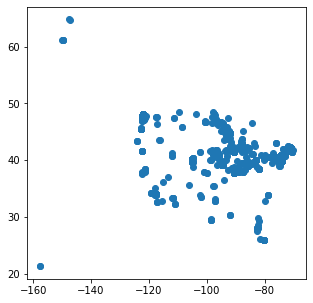

In [4]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(df['long'],df['lat']);

For some reason, this appears to include listings from nearly all 50 states, while were supposed to be focusing on just one county in Washington.

In [5]:
df['state'] = df['address'].apply(lambda x: str(x).split(' ')[-4])
df['zip'] = df['address'].apply(lambda x: str(x).split(' ')[-3].replace(',', ''))
df['city'] = df['address'].apply(lambda x: str(x).split(',')[-3].strip())

In [6]:
print('Total listings: ' + str(len(df)))
print('Out of state listings: ' + str(len(df[df['state'] != 'Washington'])))

Total listings: 30155
Out of state listings: 910


We'll get rid of out-of-state listings and look just at Washington.

In [7]:
out_of_range = set(df[df['state'] != 'Washington'].index)

df_map = df.copy()

df_map.drop(out_of_range, inplace=True)

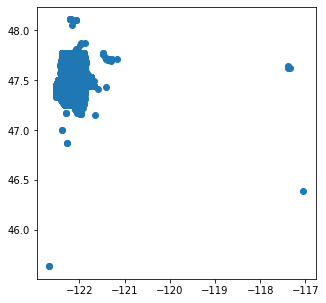

In [8]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(df_map['long'],df_map['lat']);

There are still some far-flung properties in places like Spokane. We can look up cities using long/lat approaching from all directions and eliminate anything that isn't in King County.

In [9]:
# from the east
df_map.groupby('city').mean()[['long']].sort_values('long', ascending=False)[:5]

,long
city,
Clarkston,-117.056550
Spokane,-117.375921
Skykomish,-121.332524
Snoqualmie Pass,-121.417590
Baring,-121.470469


In [10]:
out_of_range.update(df[df['city'] == 'Clarkston'].index)
out_of_range.update(df[df['city'] == 'Spokane'].index)

df_map = df.copy()

df_map.drop(out_of_range, inplace=True)

In [11]:
# from the south
df_map.groupby('city').mean()[['lat']].sort_values('lat', ascending=True)[:5]

,lat
city,
Vancouver,45.636805
Eatonville,46.876426
Spanaway,47.002985
Puyallup,47.178090
Enumclaw,47.212415


In [12]:
out_of_range.update(df[df['city'] == 'Vancouver'].index)
out_of_range.update(df[df['city'] == 'Eatonville'].index)
out_of_range.update(df[df['city'] == 'Spanaway'].index)
out_of_range.update(df[df['city'] == 'Puyallup'].index)

df_map = df.copy()

df_map.drop(out_of_range, inplace=True)

This region features two cities, Milton and Auburn, that spill over into neighboring Pierce County to the south.

In [13]:
df_map[
       (df_map['lat'] < 47.257510) &
       (df_map['long'] < -122.144411)
      ][['address', 'price', 'sqft_living', 'sqft_lot', 'bedrooms']]

,address,price,sqft_living,sqft_lot,bedrooms
1236,"4018 South 384th Street, Auburn, Washington 98...",380000.0,1250,18700,3
24148,"1901 Alder Place, Milton, Washington 98354, Un...",610000.0,1610,9644,4
27679,"98 27th Avenue, Milton, Washington 98354, Unit...",550000.0,1840,9851,4


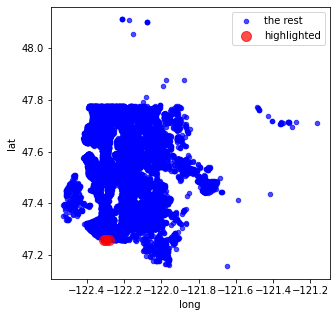

In [14]:
highlight = df_map[
#     (df_map['lat'] > 47.4) &
       (df_map['lat'] < 47.257510) &
#        (df_map['long'] > -121.93) &
       (df_map['long'] < -122.144411)
      ].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(5,5))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

There are 3 more listings that are essentially contiguous with the rest of the records, but technically belong to another county. They don't otherwise appear anomalous, so we'll keep them.

In [15]:
# from the north
df_map.groupby('city').mean()[['lat']].sort_values('lat', ascending=False)[:8]

,lat
city,
Tulalip,48.111504
Arlington,48.100735
Marysville,48.082740
Monroe,47.824948
Snohomish,47.811287
Baring,47.760969
Lake Forest Park,47.759078
Bothell,47.757407


In [16]:
out_of_range.update(df[df['city'] == 'Tulalip'].index)
out_of_range.update(df[df['city'] == 'Arlington'].index)
out_of_range.update(df[df['city'] == 'Marysville'].index)
out_of_range.update(df[df['city'] == 'Monroe'].index)
out_of_range.update(df[df['city'] == 'Snohomish'].index)

df_map = df.copy()

df_map.drop(out_of_range, inplace=True)

In [17]:
# from the west
df_map.groupby('city').mean()[['long']].sort_values('long', ascending=True)[:5]

,long
city,
Vashon,-122.467801
Dilworth,-122.439530
Dash Point,-122.416100
White Center,-122.363360
Normandy Park,-122.343426


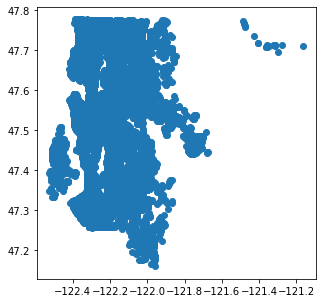

In [83]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(df_map['long'],df_map['lat']);

We'll investigate the dot by itself that's above the county line.

In [19]:
df_map.sort_values('lat', ascending=False)[:3][['lat', 'long', 'city', 'zip']]

,lat,long,city,zip
24605,47.78983,-122.097078,Woodinville,98077
25634,47.77764,-122.376830,Shoreline,98177
29110,47.77758,-122.352405,Shoreline,98133


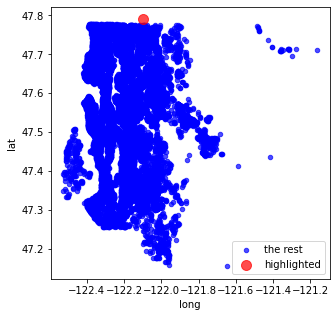

In [20]:
highlight = [24605]

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(5,5))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

The single northernmost anomalous dot is at a latitude located neither in King County nor in Woodinville. It could be an error, but we wouldn't know how to correct it, so we'll drop it.

In [21]:
out_of_range.add(24605)
df_map = df.copy()
df_map.drop(out_of_range, inplace=True)

Now we'll look at the strip of dots to the northeast along State Highway 2.

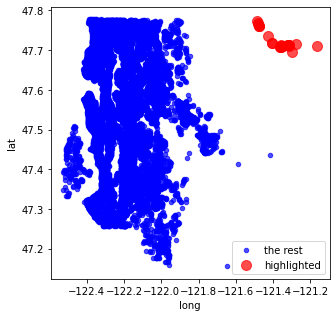

In [22]:
highlight = df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(5,5))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

In [23]:
df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)]['city'].value_counts()

Skykomish    19
Baring        7
Name: city, dtype: int64

There are 26 listings along State Highway 2 that are pretty far out from the main urban area. Rather than drop them, we'll tag them with a new column, "hwy2".

In [24]:
df['hwy2'] = df['city'].apply(lambda x: 1 if x == 'Skykomish' or x == 'Baring' else 0)

Now we'll look at the stray dot to the south.

In [25]:
df_map[(df_map['lat'] < 47.2) & (df_map['long'] > -121.8)][['city', 'lat', 'long', 'address']]

,city,lat,long,address
2930,Enumclaw,47.155265,-121.648225,"52309 SE 496th Pl, Enumclaw, Washington 98022,..."


In [26]:
df[df['city'] == 'Enumclaw']['zip'].value_counts()

98022    459
98092      1
Name: zip, dtype: int64

In [27]:
df[df['zip'] == '98092']['city'].value_counts()

Auburn      608
Enumclaw      1
Name: city, dtype: int64

This appears to be a remote community, far from the city it claims (Enumclaw) or the city normally associated with its zip code (Auburn). It doesn't appear to be an error, but it still represents a community with no immediate neighbors for comparison. As such, we'll drop it.

In [28]:
out_of_range.add(2930)
df_map = df.copy()
df_map.drop(out_of_range, inplace=True)

Now we'll look at the stray dots in the middle by pinching the latitude and searching longitude from east to west.

In [29]:
df_map[(df_map['lat'] > 47.3)
       & (df_map['lat'] < 47.6)].sort_values('long', ascending=False)[:8][['lat', 'long', 'city', 'zip']]

,lat,long,city,zip
17663,47.437030,-121.41759,Snoqualmie Pass,98045
20216,47.413610,-121.58837,North Bend,98045
14924,47.444770,-121.67469,North Bend,98045
11277,47.444905,-121.67554,North Bend,98045
28815,47.444655,-121.67839,North Bend,98045
28816,47.444745,-121.67879,North Bend,98045
8473,47.496180,-121.68674,North Bend,98045
15081,47.480100,-121.69844,North Bend,98045


Investigating these coordinates on Google Maps shows that he first three of these are something like the "Enumclaw" anomaly discussed earlier, but everything else appears to belong to a cluster worth keeping. We'll drop those three.

In [30]:
out_of_range.update(df_map[(df_map['lat'] > 47.3)
                           & (df_map['lat'] < 47.6)].sort_values('long', ascending=False)[:3].index)

df_map = df.copy()
df_map.drop(out_of_range, inplace=True)

Now we'll look at two final listings that appear remotely located from the rest.

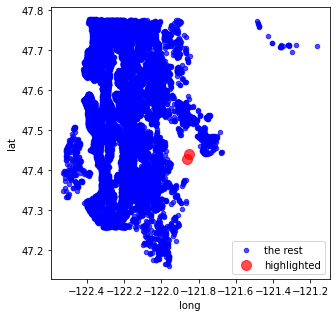

In [31]:
highlight = df_map[(df_map['lat'] > 47.4) &
       (df_map['lat'] < 47.475) &
       (df_map['long'] > -121.93) &
       (df_map['long'] < -121.8)
      ].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(5,5))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

In [32]:
df_map[(df_map['lat'] > 47.4) &
       (df_map['lat'] < 47.475) &
       (df_map['long'] > -121.93) &
       (df_map['long'] < -121.8)
      ][['address', 'price', 'grade', 'condition', 'heat_source', 'sqft_living', 'sqft_lot', 'bathrooms']]

,address,price,grade,condition,heat_source,sqft_living,sqft_lot,bathrooms
20448,"19109 364th Avenue Southeast, Maple Valley, Wa...",885000.0,8 Good,Average,Gas,2240,305355,2.0
24342,"17800 364th Avenue Southeast, Maple Valley, Wa...",1115000.0,4 Low,Average,NaN,660,1210096,1.0


One of these is a "low grade" 1-bedroom that sold for $1.115 million, which raises enough questions. It would seem fair to drop both of them.

In [33]:
out_of_range.update([20448, 24342])

df_map = df.copy()
df_map.drop(out_of_range, inplace=True)

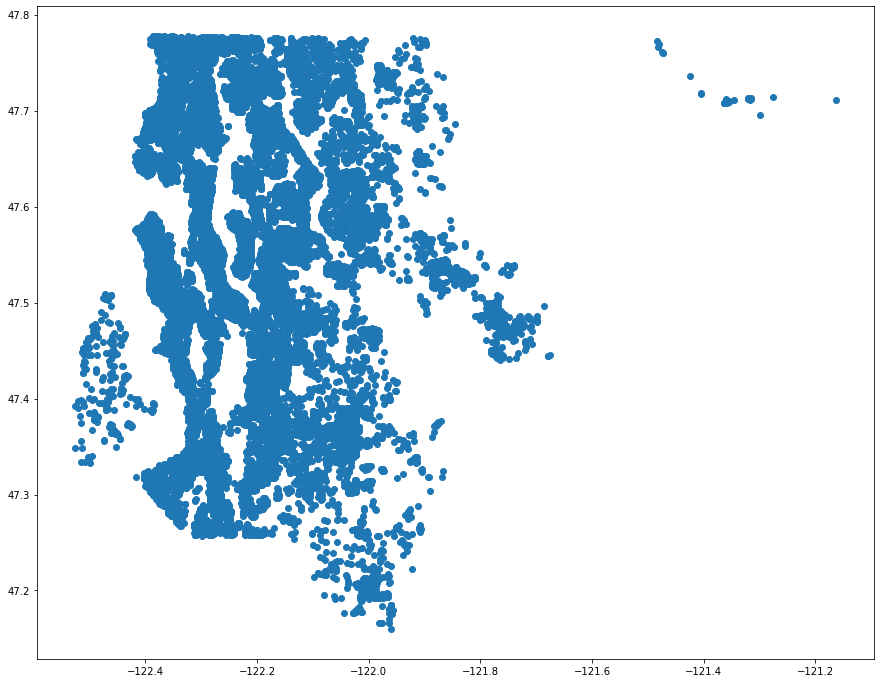

In [34]:
fig, ax = plt.subplots(figsize=(15,12))

ax.scatter(df_map['long'],df_map['lat']);

Geographically, at least, this looks like the data we want to work with.

In [35]:
print('We have dropped ' + str(len(df) - len(df_map)) + ' records, about '
      + str(round(100*(1 - len(df_map) / len(df)),2)) + '% of them.')

We have dropped 946 records, about 3.14% of them.


We'll lock in the changes to the main dataframe.

In [57]:
df = df_map.copy()

Now we'll build some functions that will give us a list of everyone's 15 to 45 closest neighbors for the purpose of comparing values with listings nearby.

In [54]:
def distance(lat1, long1, lat2, long2):
    x = abs(lat2-lat1)*364732.89
    y = abs(long2-long1)*249526.96
    return np.sqrt(x**2 + y**2)

In [67]:
def neighbors(lat, long, radius, min_neighbor_count, max_neighbor_count):
    neighbor_list = df[distance(lat, long, df['lat'], df['long']) < radius].index
    
    if len(neighbor_list) < min_neighbor_count:
        radius *= 3
        return neighbors(lat, long, radius, min_neighbor_count, max_neighbor_count)
    elif len(neighbor_list) > max_neighbor_count:
        radius /= 2
        return neighbors(lat, long, radius, min_neighbor_count, max_neighbor_count)
    else:
        return neighbor_list

In [94]:
def nearby(neighbor_list, column):
    return df.loc[neighbor_list][column].median()

In [104]:
# THIS CELL TAKES SEVERAL MINUTES TO RUN

# df['neighbor_list'] = df.apply(lambda x: neighbors(x.lat, x.long, 250, 15, 45), axis=1)
# df['nearby_price'] = df.apply(lambda x: nearby(x.neighbor_list, 'price'), axis=1)
# df['nearby_sqft_living'] = df.apply(lambda x: nearby(x.neighbor_list, 'sqft_living'), axis=1)
# df['nearby_sqft_lot'] = df.apply(lambda x: nearby(x.neighbor_list, 'sqft_lot'), axis=1)
df['nearby_ppsqft'] = df.apply(lambda x: nearby(x.neighbor_list, 'ppsqft'), axis=1)

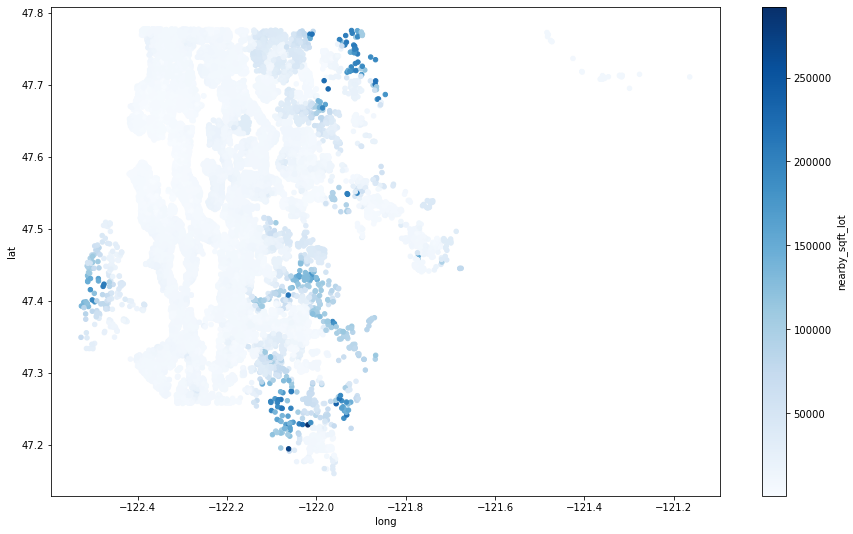

In [101]:
fig, ax = plt.subplots(figsize=(15,9))

df.plot.scatter(x='long', y='lat', c='nearby_sqft_lot', cmap='Blues', ax=ax);

# blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
# red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

Something is going on with price per square foot. Even among the highest 30 listings in that column, there is a gross outlier.

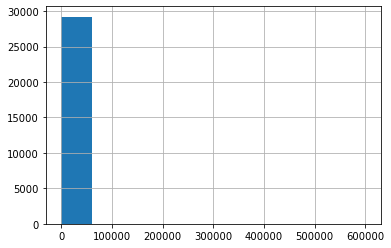

In [89]:
df['ppsqft'].hist();

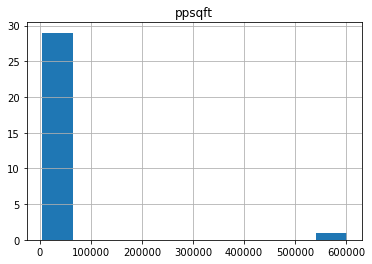

In [102]:
df.sort_values('ppsqft', ascending=False)[:30][['ppsqft']].hist();

Price per square foot climbs steeply in the top 1% (about 300 listings) and runs away even more steeply in the top 0.1% (about 30).

In [125]:
len(df[(df['ppsqft'] > 3000) & (df['sqft_living'] < 99999)])

58

In [126]:
df['ppsqft'].median()

487.7551020408163

In [130]:
df.sort_values('ppsqft', ascending=False)[:100]['city'].value_counts()

Seattle             25
Bellevue            13
Kirkland            12
Medina               8
Vashon               4
Hunts Point          4
Renton               4
Federal Way          3
Redmond              3
Mercer Island        3
Woodinville          3
Lake Forest Park     2
North Bend           2
Burien               2
Issaquah             2
Sammamish            1
Skykomish            1
Shoreline            1
Maple Valley         1
Duvall               1
Enumclaw             1
Fall City            1
Yarrow Point         1
Bothell              1
Newcastle            1
Name: city, dtype: int64

In [134]:
df[df['city']=='Seattle'].groupby('bedrooms').median()['sqft_living']

bedrooms
0     1293.0
1      740.0
2     1100.0
3     1590.0
4     2170.0
5     2740.0
6     2915.0
7     3400.0
8     3085.0
9     3050.0
11    2460.0
Name: sqft_living, dtype: float64

In [107]:
df.sort_values('ppsqft', ascending=False)[:100][[
    'bedrooms', 'ppsqft', 'nearby_ppsqft', 'price', 'nearby_price',
    'sqft_living', 'nearby_sqft_living', 'sqft_lot', 'nearby_sqft_lot']]

,bedrooms,ppsqft,nearby_ppsqft,price,nearby_price,sqft_living,nearby_sqft_living,sqft_lot,nearby_sqft_lot
14977,4,601000.000000,427.613421,1803000.0,1055125.0,3,2290.0,326701,150935.0
5811,0,48103.448276,784.836066,13950000.0,2875000.0,290,3440.0,178017,17790.0
9516,2,15584.158416,567.531424,15740000.0,1805000.0,1010,3095.0,68824,10236.5
23470,1,15073.529412,735.416667,30750000.0,2050000.0,2040,2750.0,50705,5110.0
6125,1,10000.000000,613.491245,4000000.0,1631500.0,400,2675.0,163785,10118.0
...,...,...,...,...,...,...,...,...,...
7150,3,2368.489583,739.626305,4547500.0,2030116.0,1920,2565.0,11279,14402.5
26904,3,2361.467890,740.694151,2574000.0,1093000.0,1090,1275.0,7500,7490.5
22249,0,2333.333333,315.196401,1120000.0,370000.0,480,1030.0,15000,10282.5
19049,3,2321.428571,627.155172,3250000.0,1591000.0,1400,2440.0,7293,9675.0


Let's make a price per square foot heat map (dropping the bottom and top 0.5%) and plot those top 25 on top of it.

It also seems that we'll get further with a log(price) feature.

In [ ]:
df['log(price)'] = np.log(df['price'])

In [ ]:
df['lppsqft'] = df['log(price)'] / df['sqft_living']

In [ ]:
highlight = [24605]
# highlight = df.sort_values('ppsqft', ascending=False)[:2].index
# highlight = df[df['city'] == 'Woodinville'].index
# highlight = df[df['grade'] == '10 Very Good'].index
# highlight = df[(df['lat'] > 47.6) & (df['long'] > -121.6)].index
highlight = df[df['city'] == 'Enumclaw'].index

In [ ]:
df['grade'].value_counts()

In [ ]:
blue_dots = df.drop(highlight)
red_dots = df.loc[highlight]

fig, ax = plt.subplots(figsize=(15,12))

# df.plot.scatter(x='long', y='lat', c='log(price)', cmap='Blues', ax=ax);

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

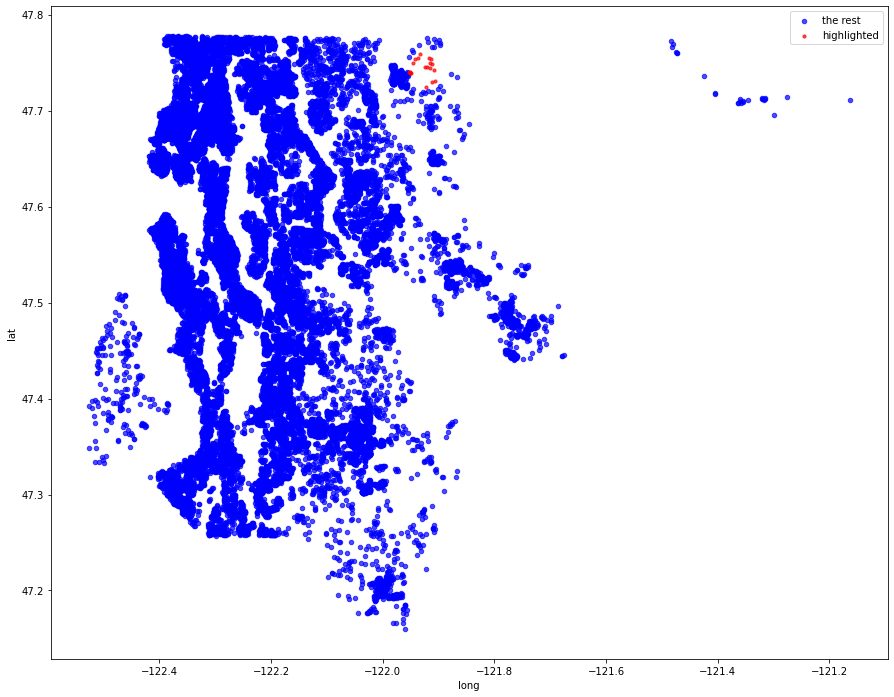

In [84]:
highlight = df.loc[14977]['neighbor_list']

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(15,12))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=10, ax=ax, label='highlighted')

ax.legend();

In [ ]:
df.iloc[highlight]['sqft_living']

In [ ]:
df['price'].describe()

In [ ]:
df.skew()

In [ ]:
df['condition'].value_counts()

In [ ]:
df['view'].value_counts()

# Baseline Model

We'll start with a baseline model using all the data from the listings we've narrowed down so far

## Sort columns into groups

In [ ]:
numeric_continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio']
numeric_discrete = ['bedrooms', 'bathrooms', 'floors', 'yr_built', 'yr_renovated']
categorical = ['waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade', 'heat_source', 'sewer_system']
specials = ['date', 'address', 'lat', 'long']

create dataframes from groups

shift the mean to zero for continuous variables

one-hot encode categorical variables

In [ ]:
df_numeric_continuous = df[numeric_continuous].copy()
for column in numeric_continuous:
    df_numeric_continuous[column] = df_numeric_continuous[column] - df_numeric_continuous[column].mean()

df_numeric_discrete = df[numeric_discrete].copy()

df_categorical = df[categorical].copy()
df_categorical = pd.get_dummies(df_categorical, columns = categorical)
df_categorical.drop(columns = ['waterfront_NO', 'greenbelt_NO', 'nuisance_NO',
                               'view_NONE', 'condition_Average', 'grade_7 Average',
                               'heat_source_Other', 'sewer_system_PUBLIC'], axis = 1, inplace = True)

run the model

In [ ]:
y = df['price']
X_baseline = pd.concat([df_numeric_continuous, df_numeric_discrete, df_categorical], axis = 1)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

## comment on the baseline model

In [ ]:
# collect a list of outlier data past a certain threshold of standard deviations

threshold = 6
outliers = set()

outliers = set(df[df['price'] > df['price'].mean() + threshold * df['price'].std()].index)

len(outliers)

In [ ]:
y = df['price'].drop(outliers)
X_baseline = pd.concat([df_numeric_continuous, df_numeric_discrete, df_categorical], axis = 1).drop(outliers)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

# make basic adjustments

customize one-hot encoding for heat source, given that some entries have multiple heat sources.

In [ ]:
df['gas'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Gas' else 0)
df['electricity'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Ele' else 0)
df['oil'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Oil' else 0)
df['solar'] = df['heat_source'].apply(lambda x: 1 if str(x)[-5:] == 'Solar' else 0)
del df['heat_source']

customize label-encoding for view, condition, and grade

In [ ]:
def view(x):
    if x == 'NONE':
        return 0
    elif x == 'FAIR':
        return 1
    elif x == 'AVERAGE':
        return 2
    elif x == 'GOOD':
        return 3
    elif x == 'EXCELLENT':
        return 4

df['view'] = df['view'].apply(lambda x: view(x))

def condition(x):
    if x == 'Poor':
        return 0
    elif x == 'Fair':
        return 1
    elif x == 'Average':
        return 2
    elif x == 'Good':
        return 3
    elif x == 'Very Good':
        return 4

df['condition'] = df['condition'].apply(lambda x: condition(x))

df['grade'] = df['grade'].apply(lambda x: int(x[:2].strip()))

reset the groups

In [ ]:
numeric_continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio']
numeric_discrete = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated']
categorical = ['waterfront', 'greenbelt', 'nuisance', 'sewer_system']
heat = ['gas', 'electricity', 'oil', 'solar']
specials = ['date', 'address', 'lat', 'long']

create dataframes from groups

shift the mean to zero for continuous variables

one-hot encode categorical variables

In [ ]:
df_numeric_continuous = df[numeric_continuous].copy()
for column in numeric_continuous:
    df_numeric_continuous[column] = df_numeric_continuous[column] - df_numeric_continuous[column].mean()

df_numeric_discrete = df[numeric_discrete].copy()

df_categorical = df[categorical].copy()
df_categorical = pd.get_dummies(df_categorical, columns = categorical)
df_categorical.drop(columns = ['waterfront_NO', 'greenbelt_NO',
                               'nuisance_NO', 'sewer_system_PUBLIC'], axis = 1, inplace = True)

df_heat = df[heat].copy()

run the model

In [ ]:
y = df['price']
X_baseline = pd.concat([df_numeric_continuous, df_numeric_discrete, df_categorical, df_heat], axis = 1)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

removing bad correlations: greenbelt, heat source, (some) sewers

In [ ]:
del df_categorical['greenbelt_YES']
del df_categorical['sewer_system_PRIVATE RESTRICTED']
del df_categorical['sewer_system_PUBLIC RESTRICTED']

run the model

In [ ]:
y = df['price']
X_baseline = pd.concat([df_numeric_continuous, df_numeric_discrete, df_categorical, df_heat], axis = 1)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

removing outliers

In [ ]:
# collect a list of outlier data past a certain threshold of standard deviations

threshold = 6
outliers = set()

outliers = set(df[df['price'] > df['price'].mean() + threshold * df['price'].std()].index)
    
len(outliers)

run the model

In [ ]:
y = df['price'].drop(outliers)
X_baseline = pd.concat([df_numeric_continuous, df_numeric_discrete, df_categorical, df_heat], axis = 1).drop(outliers)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

removing outliers from the numeric variables doesn't seem to change R-squared much at all (at best, improves from 0.490 to 0.491 without changing Adj. R-squared) but removing about 100 outliers (6 stds) improves R-squared to 0.546

# Evaluation